In [162]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [163]:
with open('detected/english~meta-llama-Llama-3.1-8B~UnigramWatermarkedLLM~.json') as f:
    data = json.load(f)
with open('not-detected/english~meta-llama-Llama-3.1-8B~UnigramWatermarkedLLM~.json') as f:
    data2 = json.load(f)

In [164]:
print(data[:100])

[{'z_score': 14.14060666155299, 'p_value': None, 'error': 'none', 'generated_class_name': 'UnigramWatermarkedLLM', 'generated_model_name': 'meta-llama-Llama-3.1-8B', 'generated_green_list_size': 0.5, 'generated_wm_strength': 2, 'generated_watermark_key': 1615453454534154, 'detected_class_name': 'UnigramWatermarkedLLM', 'detected_model_name': 'meta-llama-Llama-3.1-8B', 'detected_green_list_size': 0.5, 'detected_wm_strength': 2, 'detected_watermark_key': 1615453454534154, 'generated_token_len': 370}, {'z_score': 13.466098264498733, 'p_value': None, 'error': 'none', 'generated_class_name': 'UnigramWatermarkedLLM', 'generated_model_name': 'meta-llama-Llama-3.1-8B', 'generated_green_list_size': 0.5, 'generated_wm_strength': 2, 'generated_watermark_key': 1615453454534154, 'detected_class_name': 'UnigramWatermarkedLLM', 'detected_model_name': 'meta-llama-Llama-3.1-8B', 'detected_green_list_size': 0.5, 'detected_wm_strength': 2, 'detected_watermark_key': 1615453454534154, 'generated_token_len'

In [165]:
# Filter only those where generated_model_name is: meta-lllama-Llama-3.1-8B
data = [x for x in data if x['generated_model_name'] == 'meta-llama-Llama-3.1-8B' and x['detected_model_name'] == 'meta-llama-Llama-3.1-8B']

In [166]:
print(len(data2["data"]))
print(len(data))

7711
7711


In [167]:
filtered_data = []
for d1, d2 in zip(data, data2["data"]):
    zscore = d1["z_score"]
    token_length = d1["generated_token_len"]
    entropy = d2["entropy"]
    filtered_data.append({
        "z_score": zscore,
        "token_length": token_length,
        "entropy": entropy
    })

In [168]:
# Create a dataframe
df = pd.DataFrame(filtered_data)
# Filter empty token lengths
df = df[df["token_length"] > 3]

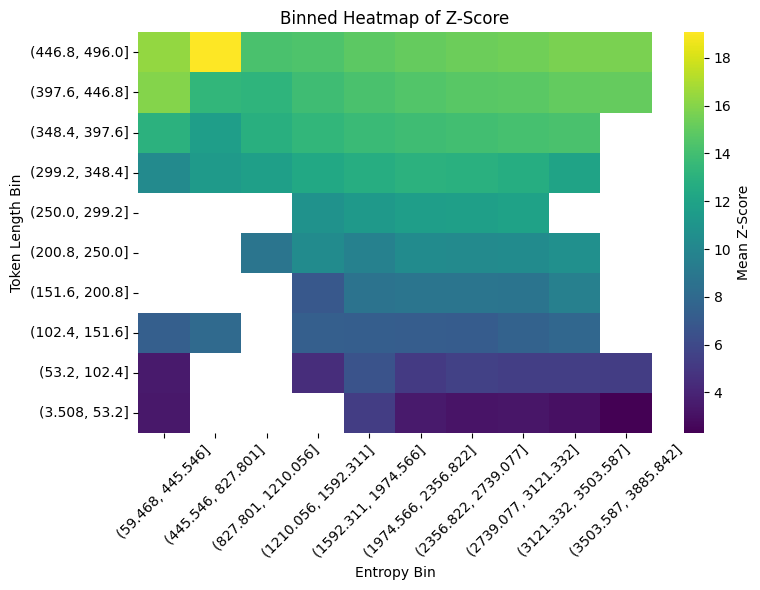

In [169]:
# Create a heatmap with the data
num_bins = 10  # Adjust the number of bins as needed
# Copy of df
df_copy = df.copy()
df_copy['token_length_bin'] = pd.cut(df_copy['token_length'], bins=num_bins)
df_copy['entropy_bin'] = pd.cut(df_copy['entropy'], bins=num_bins)

# Group by bins and calculate the mean z_score for each tile
heatmap_data = df_copy.groupby(['token_length_bin', 'entropy_bin'])['z_score'].mean().unstack()
heatmap_data = heatmap_data.iloc[::-1]


# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="viridis", annot=False, cbar_kws={'label': 'Mean Z-Score'})
plt.title("Binned Heatmap of Z-Score")
plt.xlabel("Entropy Bin")
plt.ylabel("Token Length Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("heatmap.png")
plt.show()

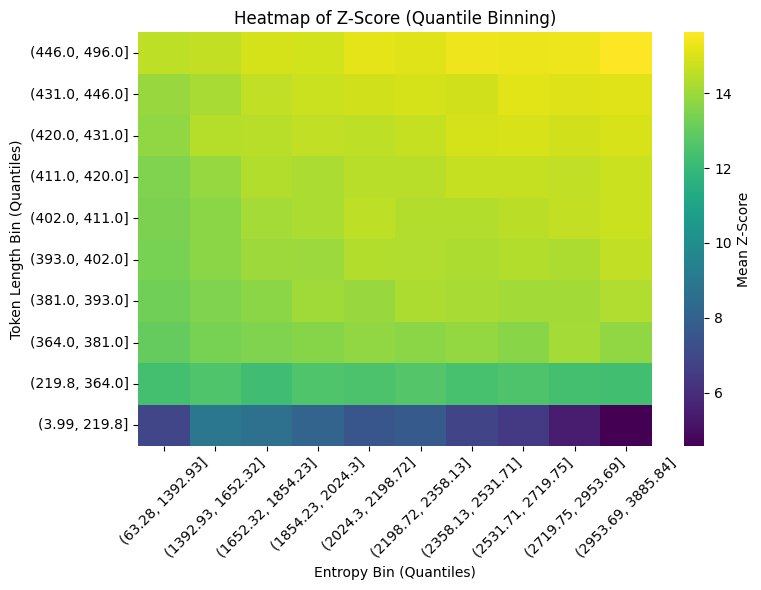

In [170]:
num_bins = 10  # Adjust as needed

# Create quantile bins for 'token_length' and 'entropy'
df['token_length_bin'] = pd.qcut(df['token_length'], q=num_bins, precision=2)
df['entropy_bin'] = pd.qcut(df['entropy'], q=num_bins, precision=2)

# Group by quantile bins and calculate the mean z_score for each tile
heatmap_data = df.groupby(['token_length_bin', 'entropy_bin'])['z_score'].mean().unstack()

# Reverse the order of the token_length axis
heatmap_data = heatmap_data.iloc[::-1]

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap="viridis", annot=False, cbar_kws={'label': 'Mean Z-Score'})
plt.title("Heatmap of Z-Score (Quantile Binning)")
plt.xlabel("Entropy Bin (Quantiles)")
plt.ylabel("Token Length Bin (Quantiles)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("heatmap_quantile.png")
plt.show()